In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

In [17]:
import spotipy
import datetime
import threading
import logging
import time
import itertools
from spotipy.oauth2 import SpotifyOAuth
import smtplib
from email.mime.text import MIMEText
from collections import Counter
import csv

client_id = "YOUR_CLIENT_ID_HERE"
client_secret = "YOUR_CLIENT_SECRET_HERE"
redirect_uri = "http://localhost:9999/callback"

In [18]:
seen_tracks_playlist_id = "5al4jEBoq01LPmFDuGDnq4"          # Automated: Reviewed Items
seen_tracks_backup_playlist_id = "6LszTDYqWtsxBj8iDTA5Ou"   # Automated: Reviewed Backup
temp_review_clone_id = "5PGCp1CjpaV5DmqdyjSnTt"             # Automated: Temp Review Clone
inbox_playlist_id = "1xsuqA0HU4bSosdaPyVlWG"                # 1 Esh Review
shortlist_playlist_id = "3qYnDeorQj7TPRlmqM8S5c"            # 2 Esh Shortlist
approved_playlist_id = "7pBxidVP9h7ufxsFBMwOQq"             # 3 Esh Approved
previously_played_playlist_id = "7EHT9D4ygqDlyGfqcFvkUv"    # 5 Esh Played
tracked_playlist_id = "5PR4b0qnkhfCUdt4oLbn3o"              # X Esh Tracked
ml_test_playlist_id = "1N3g2lFG8fW3W7ecyQTD07"              # Test

In [19]:
def get_all_playlist_tracks(sp,playlist_id):
    results = sp.playlist_tracks(playlist_id)
    playlist_tracks = results['items']
    while results['next']:
        results = sp.next(results)
        playlist_tracks.extend(results['items'])
    return [playlist_track['track'] for playlist_track in playlist_tracks]

def get_all_playlist_tracks_extended(sp,playlist_id):
    def add_features(playlist_tracks):
        tracks = [pt['track'] for pt in playlist_tracks]
        track_features = sp.audio_features([t["id"] for t in tracks])
        return list(zip(tracks,track_features))
    results = sp.playlist_tracks(playlist_id)
    collected_tracks = add_features(results['items'])
    while results['next']:
        results = sp.next(results)
        collected_tracks.extend(add_features(results['items']))
    return collected_tracks

def add_all_playlist_tracks(sp,playlist_id,tracks):
    while True:
        if not tracks:
            return
        current_batch = tracks[:100]
        tracks = tracks[100:]
        sp.playlist_add_items(playlist_id,current_batch)
        
def remove_all_track_ids_from_playlist(sp,playlist_id,track_ids):
    while True:
        if not track_ids:
            return
        current_batch = track_ids[:100]
        track_ids = track_ids[100:]
        sp.playlist_remove_all_occurrences_of_items(playlist_id,current_batch)

def truncate_playlist(sp,playlist_id):
    current_tracks = get_all_playlist_tracks(sp,playlist_id)
    remove_all_track_ids_from_playlist(sp,playlist_id,[track["id"] for track in current_tracks])
    
def parse_date(date_string):
    for fmt in ("%Y-%m-%d","%Y","%Y-%m"):
        try:
            return datetime.datetime.strptime(date_string, fmt)
        except:
            pass
    print("Skipping a weird date: " + date_string)
    return None

def is_new_track(track):
    release_date = parse_date(track["album"]["release_date"])
    return release_date is not None and (datetime.datetime.today() - release_date).days <= 60

def strip_casefold_compare(s1,s2):
    return s1.casefold().strip() == s2.casefold().strip()

def is_seen_track(track,seen_tracks):
    for seen_track in seen_tracks:
        if seen_track["id"] == track["id"]:
            return True       
        if strip_casefold_compare(track["name"],seen_track["name"]) and track["artists"]==seen_track["artists"]:
            return True
    return False

def filter_tracks(tracks,seen_tracks,albums_counter=dict()):
    new_tracks = []
    for track in tracks:
        if not track or is_seen_track(track,seen_tracks) or not is_new_track(track):
            continue
        album_id = track["album"]["id"]
        if album_id not in albums_counter:
            albums_counter[album_id] = 0
        albums_counter[track["album"]["id"]]+=1
        if albums_counter[track["album"]["id"]]>max_items_per_album:
            continue
        new_tracks.append(track)
    return new_tracks
    
def extract_ids(items):
    return [item["id"] for item in items]

def get_track_details(track,features):
    details = dict()
    details["id"]=track["id"]
    details["name"]=track["name"]
    details["album_id"]=track["album"]["id"]
    details["album_name"]=track["album"]["name"]
    details["artist_id"]=track["artists"][0]["id"]
    details["artist_name"]=track["artists"][0]["name"]
    details["duration"]=track["duration_ms"]
    details["popularity"]=track["popularity"]
    if not features:
        return None
    for f in ["acousticness","danceability","energy","instrumentalness","liveness","loudness","speechiness","tempo","valence"]:
        details[f] = features[f]
    return details

In [20]:
scope = "playlist-modify-private"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope,client_id=client_id,client_secret=client_secret,redirect_uri=redirect_uri))

In [21]:
test_tracks = get_all_playlist_tracks_extended(sp,ml_test_playlist_id)

In [22]:
tracks_details = [get_track_details(t,f) for (t,f) in test_tracks]
tracks_details = list(filter(None, tracks_details))

In [23]:
with open(r'C:\Users\opben\OneDrive\Documents\Esh Release Radar\data.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, tracks_details[0].keys())
    dict_writer.writeheader()
    dict_writer.writerows(tracks_details)

In [11]:
with open(r'C:\Users\opben\OneDrive\Documents\Esh Release Radar\data.csv', 'r', newline='') as data_file:
    tracks_details = list(csv.DictReader(data_file))

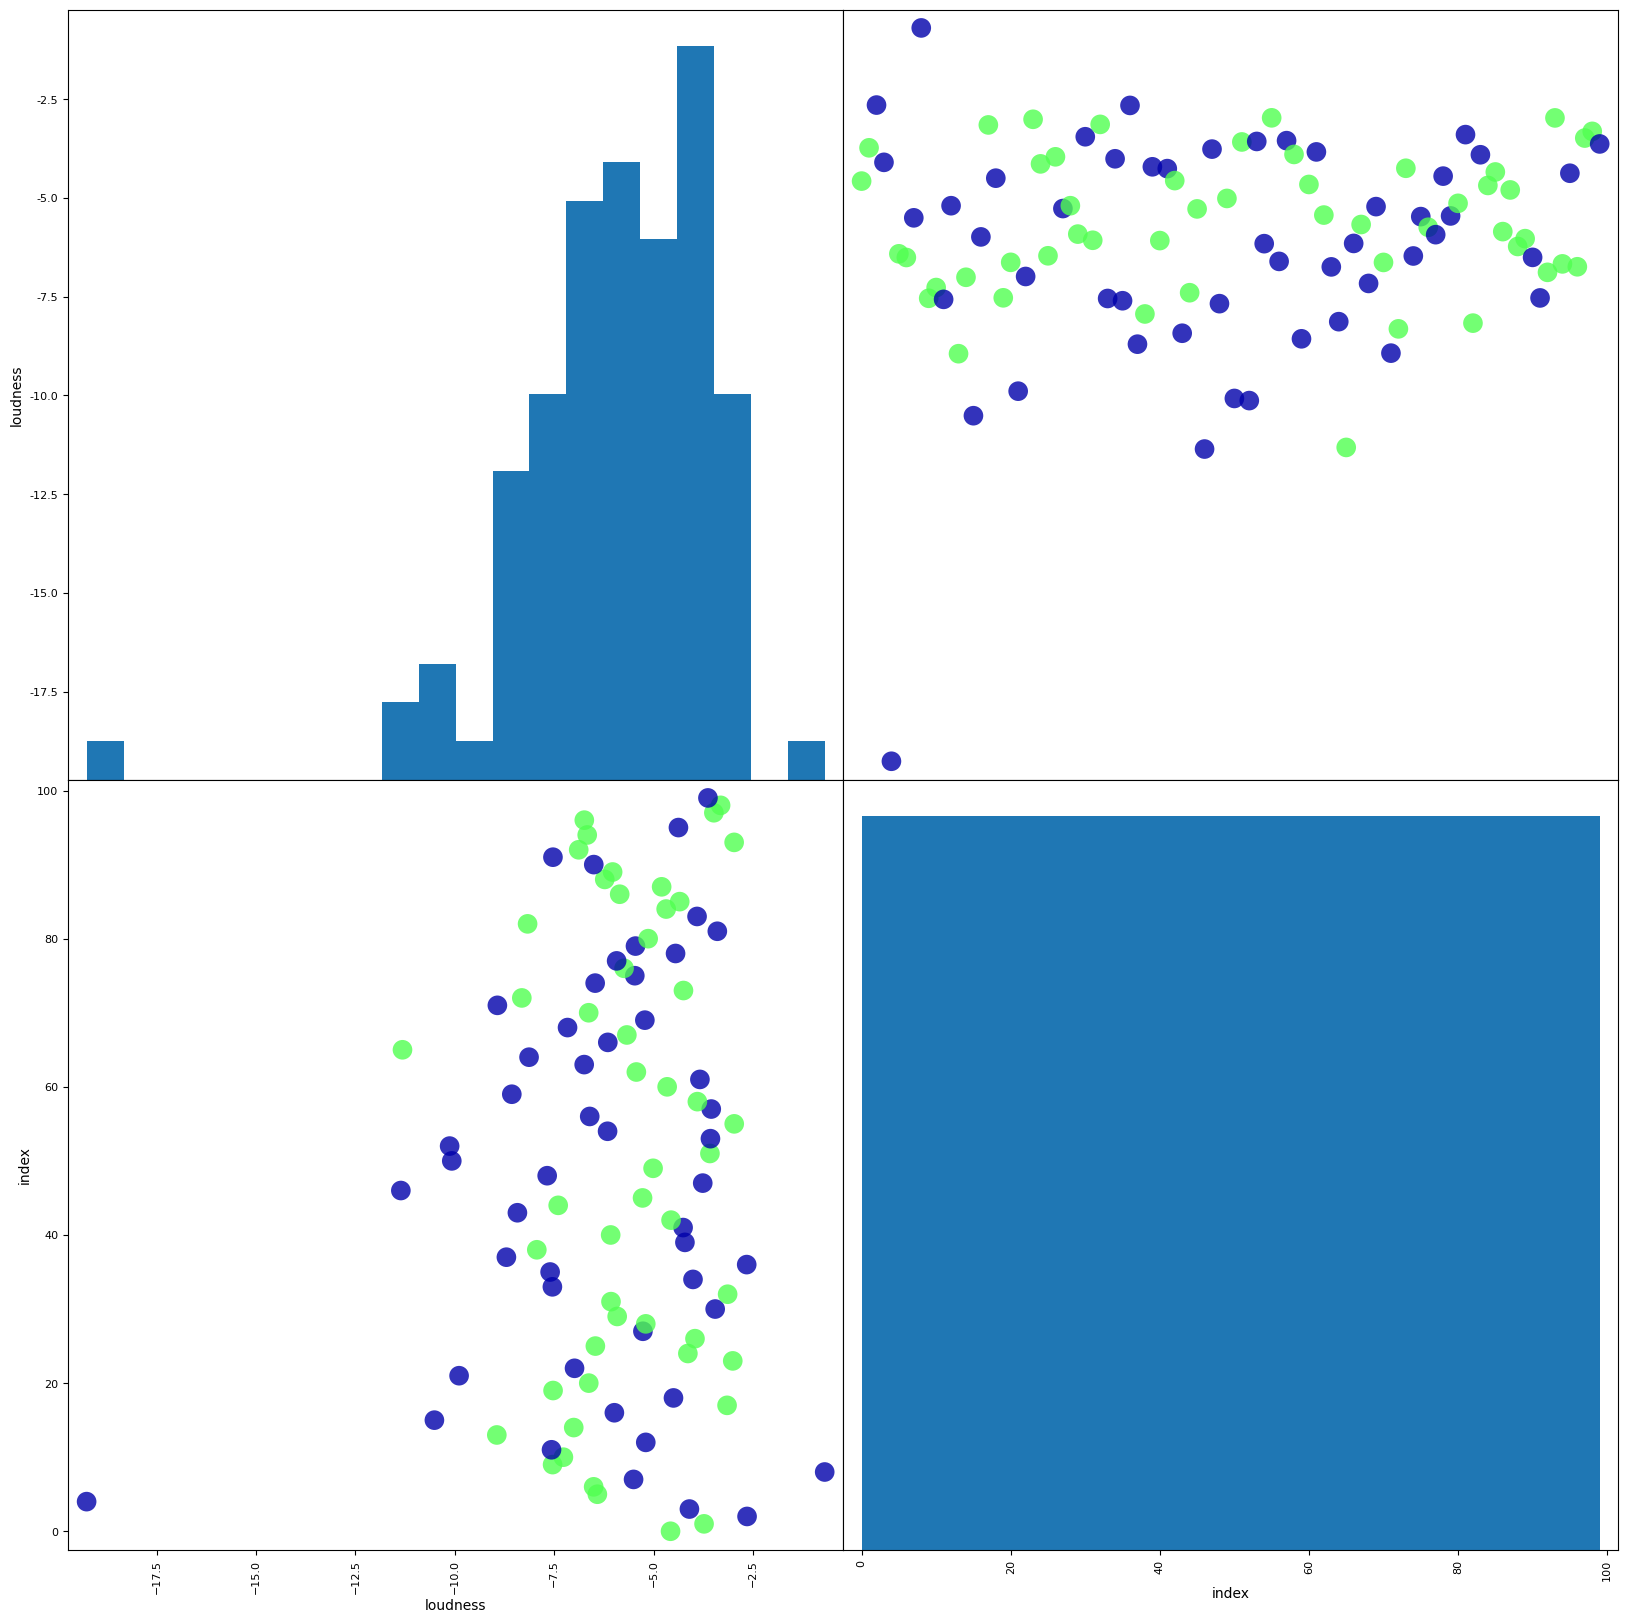

In [68]:
import random

def dict_pop_and_remove(d,k):
    return ({i:d[i] for i in d if i!=k},d[k])

def shuffle_in_place(l):
    return random.sample(l,len(l))

def dict_keep_keys(d,ks):
    return {i:d[i] for i in d if i in ks}

features = ["played","loudness"]

tracks_details_reduced = list(map(lambda d:dict_keep_keys(d,features),tracks_details))

played,skipped = [],[]
for (track,is_played) in map(lambda d: dict_pop_and_remove(d,'played'),tracks_details_reduced):
    (played,skipped)[int(is_played)].append((track,int(is_played)))
sample_size = 50
sample_scored_tracks = shuffle_in_place(random.sample(played,sample_size) + random.sample(skipped,sample_size))

for i,(d,p) in enumerate(sample_scored_tracks):
    d["index"] = i
    
sample_tracks,sample_score = list(zip(*sample_scored_tracks))


sample_tracks_arr = np.array([list(d.values()) for d in sample_tracks]).astype(float)
sample_score_arr = np.array(sample_score).astype(int)
sample_tracks_df = pd.DataFrame(sample_tracks_arr,columns=sample_tracks[0].keys())
pd.plotting.scatter_matrix(sample_tracks_df,c=sample_score_arr,figsize=(20,20),marker='o',hist_kwds={'bins':20},s=200,alpha=.8,cmap=mglearn.cm3)
plt.show()

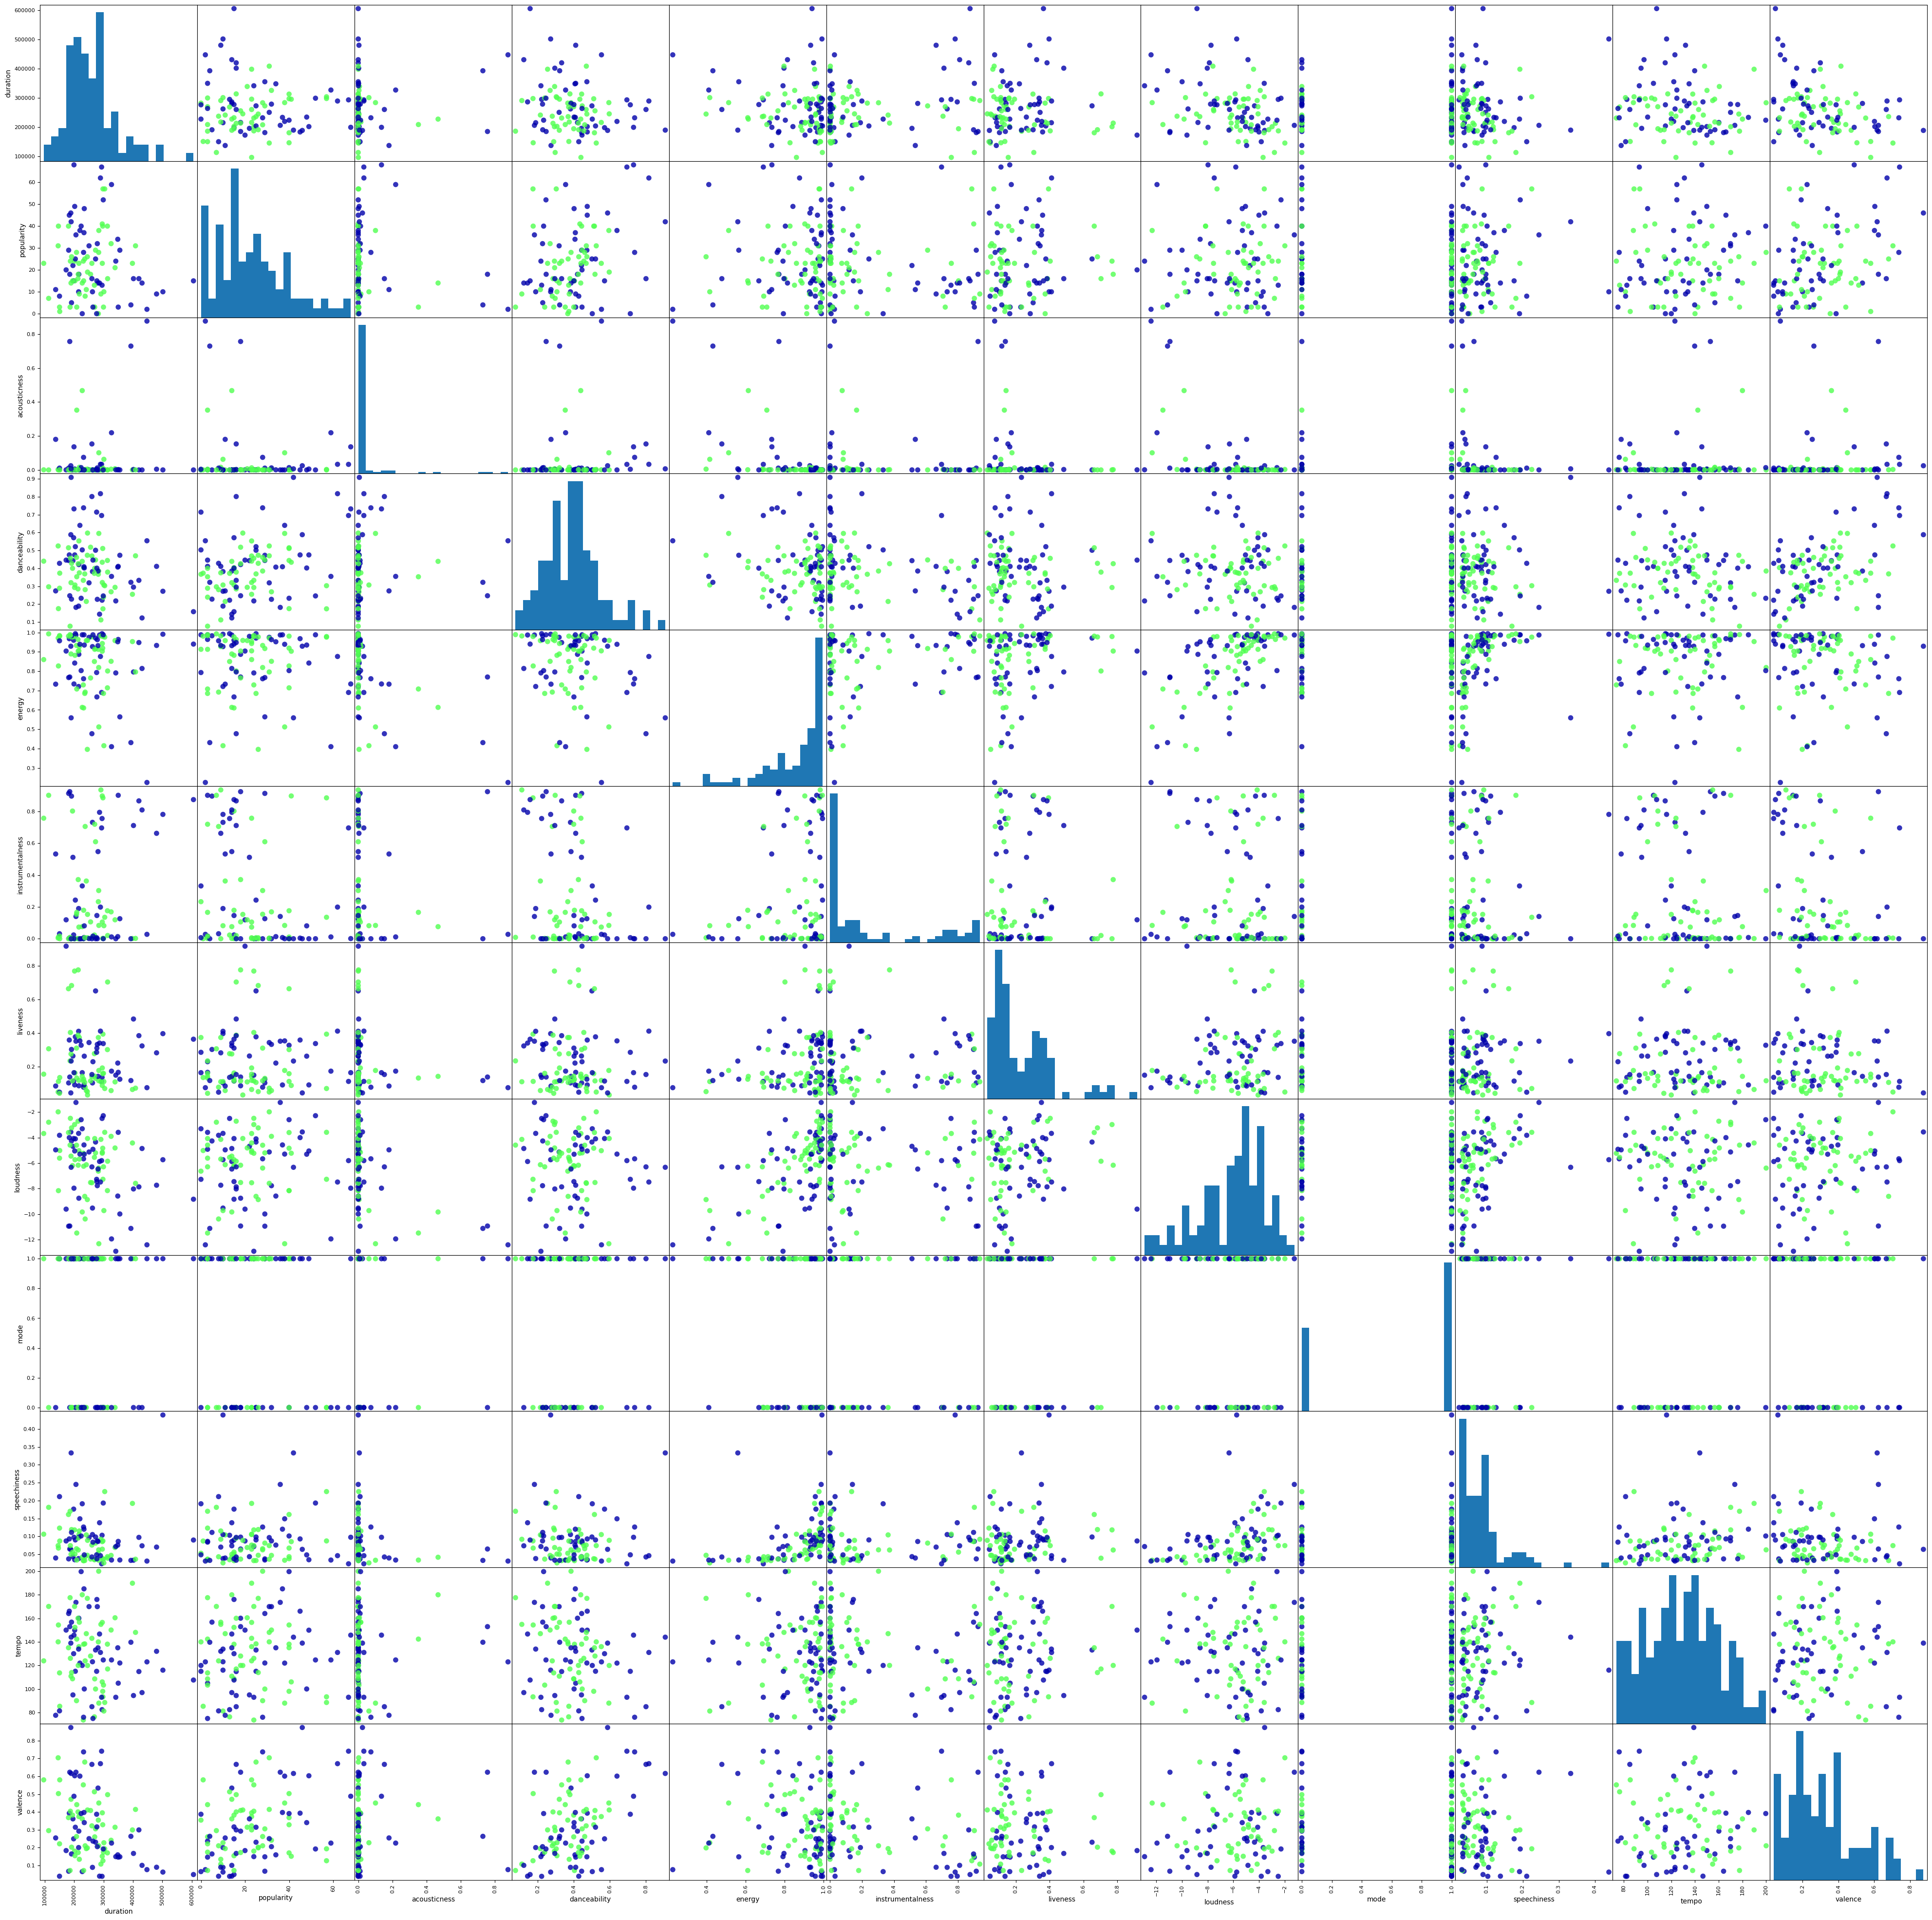

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(tracks_array,tracks_played,random_state=0)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score: {:.2f}".format(knn.score(X_test,y_test)))

Test set score: 0.94


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [63]:
def get_track_details2(track,features):
    details = dict()
    details["duration"]=track["duration_ms"]
    details["popularity"]=track["popularity"]
    if not features:
        return None
    for f in ["acousticness","danceability","energy","instrumentalness","liveness","loudness","speechiness","tempo","valence"]:
        details[f] = features[f]
    return details

review_tracks = get_all_playlist_tracks_extended(sp,inbox_playlist_id)
for (t,f) in review_tracks:
    details = list(get_track_details2(t,f).values())
    arr = np.array(np.array([details])).astype(float)
    print(t["name"] + ": " + str(knn.predict(arr)))

Disbelief: [0.]
Antechamber of the Wakeless Mind: [0.]
Paralyzed: [0.]
Smertens Vilje: [0.]
Anchors Of Our History: [0.]
Better Off Dead: [0.]
Dig My Grave: [0.]
Death Throne: [0.]
Suffering Is a Gift from God: [0.]
Final Kingdom: [0.]
KILLING PEOPLE FOR THE BETTERMENT OF THE PLANET: [0.]
Outer Gods Exodvs: [0.]
Antigone: [0.]
These Two Sides Are Not Part of the Same Coin: [0.]
Seraph: [0.]
Oath of Forgotten Past: [0.]
Praise You: [0.]
Elegy: [0.]
Obliterate: [0.]
Embers: [0.]
Vad vill du ha: [0.]
Joie: [0.]
We Are the Chosen: [0.]
Dark: [0.]
Fat Old Sun: [0.]
Foot Wrong: [0.]
Unity of Opposites: [0.]
Thriller: [0.]
Mundus Imaginalis: [0.]
Ambivalence 2.0: [0.]
A Gentleman’s Gentleman (Live): [0.]
I Don't Smoke Angel Dust Anymore (So Don't Be Afraid): [0.]
Asas de Mosca: [0.]
Eternal Fire: [0.]
STIGMVTA: [0.]
555: [0.]
НОВОЕ НОВОЕ: [0.]
Variegated Stances of Self Mockery: [0.]
Innsikt: [0.]
Liquified Sexualities: [0.]
Ivory: [0.]
Void: [0.]
Emolecule: [0.]
talk more: [0.]
Fingers of St

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim